# Job Advertisement Classification

## Import Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

import gensim.downloader as api

from scipy.sparse import hstack

### Utilities

In [5]:
def validator(data_features, vocab, a_ind, tokenised_articles, web_indexes, description_txts):
    print("Webindex:", web_indexes[a_ind]) # print out the Article ID
    print("--------------------------------------------")
    print("Description:",description_txts[a_ind]) # print out the txt of the article
    print("Description tokens:",tokenised_articles[a_ind]) # print out the tokens of the article
    print("--------------------------------------------\n")
    print("Vector representation:\n") # printing the vector representation as format 'word:value' (
                                      # the value is 0 or 1 in for binary vector; an integer for count vector; and a float value for tfidf

    for word, value in zip(vocab, data_features.toarray()[a_ind]): 
        if value > 0:
            print(word+":"+str(value), end =' ')

In [6]:
def gen_docVecs(wv,tk_txts,tfidf = []): # generate vector representation for documents
    docs_vectors = pd.DataFrame() # creating empty final dataframe
    #stopwords = nltk.corpus.stopwords.words('english') # removing stop words

    for i in range(0,len(tk_txts)):
        tokens = list(set(tk_txts[i])) # get the list of distinct words of the document

        temp = pd.DataFrame()  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
        for w_ind in range(0, len(tokens)): # looping through each word of a single document and spliting through space
            try:
                word = tokens[w_ind]
                word_vec = wv[word] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed

                if tfidf != []:
                    word_weight = float(tfidf[i][word])
                else:
                    word_weight = 1
                temp = pd.concat([temp, pd.Series(word_vec*word_weight).to_frame().T], ignore_index = True) # if word is present then append it to temporary dataframe
            except:
                pass
        doc_vector = temp.sum().to_frame().T # take the sum of each column(w0, w1, w2,........w300)
        docs_vectors = pd.concat([docs_vectors,doc_vector], ignore_index = True) # append each document value to the final dataframe
    return docs_vectors

In [7]:
def write_vectorFile(data_features,filename, web_indexes):
    num = data_features.shape[0] # the number of document
    out_file = open(filename, 'w') # creates a txt file and open to save the vector representation
    for a_ind in range(0, num): # loop through each article by index
        out_file.write("{},".format(web_indexes[a_ind]))
        for f_ind in data_features[a_ind].nonzero()[1]: # for each word index that has non-zero entry in the data_feature
            value = data_features[a_ind][0,f_ind] # retrieve the value of the entry from data_features
            out_file.write("{}:{},".format(f_ind,value)) # write the entry to the file in the format of word_index:value
        out_file.write('\n') # start a new line after each article
    out_file.close() # close the file

In [8]:
def plotTSNE(labels,features): # features as a numpy array, each element of the array is the document embedding of an article
    categories = sorted(labels.unique())
    # Sampling a subset of our dataset because t-SNE is computationally expensive
    SAMPLE_SIZE = int(len(features) * 0.3)
    np.random.seed(0)
    indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
    projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
    colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
    for i in range(0,len(categories)):
        points = projected_features[(labels[indices] == categories[i])]
        plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[i], label=categories[i])
    plt.title("Feature vector for each article, projected on 2 dimensions.",
              fontdict=dict(fontsize=15))
    plt.legend()
    plt.show()

## 1. Load Data

### Descriptions

In [11]:
txt_fname = 'descriptions.txt'
with open(txt_fname) as txtf:
    description_txts = txtf.read().splitlines() # reading a list of strings, each for a document/article
tk_descriptions = [a.split(' ') for a in description_txts]

In [12]:
with open("./vocab.txt", 'r') as vocab_file:
    vocab = vocab_file.read().splitlines()
voc_dict = {int(w.split(":")[1]):w.split(":")[0] for w in vocab}
vocab = [w.split(":")[0] for w in vocab]

In [13]:
with open("./web_indexes.txt", 'r') as web_indexes_f:
    web_indexes = web_indexes_f.read().splitlines()

In [14]:
txt_fname = 'descriptions_txt.txt'
with open(txt_fname) as txtf:
    description_txts = txtf.read().splitlines() # reading a list of strings, each for a document/article

### Titles

In [16]:
with open("./titles_vocab.txt", 'r') as titles_vocab_file:
    titles_vocab = titles_vocab_file.read().splitlines()
titles_voc_dict = {int(w.split(":")[1]):w.split(":")[0] for w in titles_vocab}
titles_vocab = [w.split(":")[0] for w in titles_vocab]

In [17]:
title_txt_fname = 'titles.txt'
with open(title_txt_fname) as titles_txtf:
    titles_txts = titles_txtf.read().splitlines() # reading a list of strings, each for a document/article
tk_titles = [a.split(' ') for a in titles_txts]

### Descriptions

In [19]:
cat_fname = './categories.txt'
with open(cat_fname) as catf: 
    categories = catf.read().splitlines() # read all the sentiments into a list

## 2. Generating Feature Representations for Job Advertisement Descriptions

### 2.1. Generatin Count Vectors

In [22]:
cVectorizer = CountVectorizer(analyzer = "word",vocabulary = vocab) # initialised the CountVectorizer

In [23]:
count_features = cVectorizer.fit_transform([" ".join(descr) for descr in tk_descriptions]) # generate the count vector representation for all articles
print(count_features.shape)

(776, 5173)


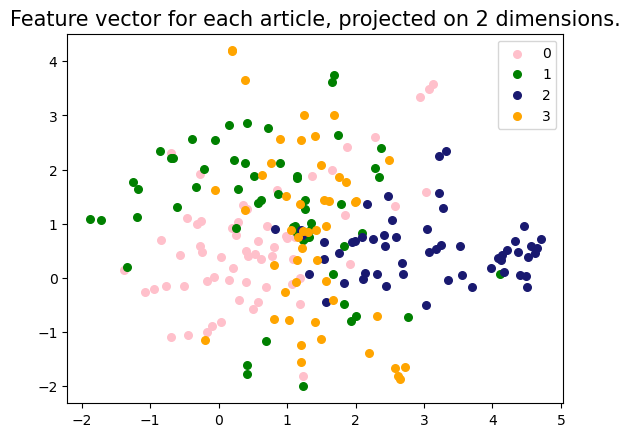

In [24]:
plotTSNE(pd.Series(categories), count_features.toarray())

### 2.2. Generating TF-IDF Vectors

In [26]:
tVectorizer = TfidfVectorizer(analyzer = "word",vocabulary = vocab) # initialised the TfidfVectorizer

In [27]:
tfidf_features = tVectorizer.fit_transform([" ".join(descr) for descr in tk_descriptions]) # generate the tfidf vector representation for all articles
tfidf_features.shape

(776, 5173)

In [28]:
tfidf_weights = [{voc_dict[f_ind]: tv[0,f_ind] for f_ind in tv.nonzero()[1]} for tv in tfidf_features]

In [29]:
validator(tfidf_features, vocab, 0, tk_descriptions, web_indexes, description_txts)

Webindex: 68997528
--------------------------------------------
Description: Accountant (partqualified) to **** p.a. South East London Our client, a successful manufacturing company has an immediate requirement for an Accountant for permanent role in their modern offices in South East London. The Role: Credit Control Purchase / Sales Ledger Daily collection of debts by phone, letter and email. Handling of ledger accounts Handling disputed accounts and negotiating payment terms Allocating of cash and reconciliation of accounts Adhoc administration duties within the business The Person The ideal candidate will have previous experience in a Credit Control capacity, you will possess exceptional customer service and communication skills together with IT proficiency. You will need to be a part or fully qualified Accountant to be considered for this role
Description tokens: ['accountant', 'partqualified', 'south', 'east', 'london', 'manufacturing', 'requirement', 'accountant', 'permanent', 'm

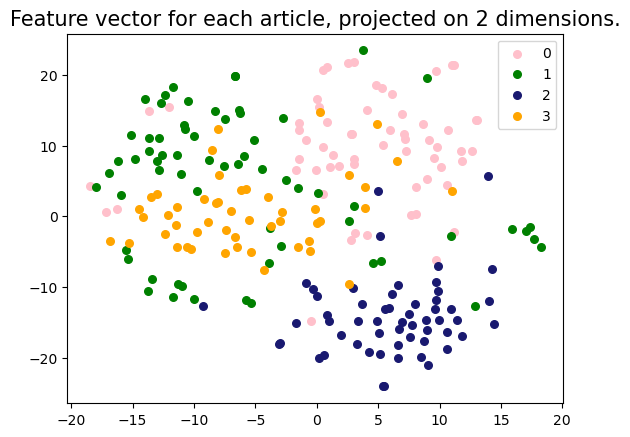

In [30]:
plotTSNE(pd.Series(categories), tfidf_features.toarray())

### 2.3. Doc2Vec

In [32]:
# loading the pre-trained word2vec model based on google news
preTW2v_wv = api.load('word2vec-google-news-300')

#### Unweighted

In [34]:
unweighted_preTW2v_dvs = gen_docVecs(preTW2v_wv, tk_descriptions)

In [35]:
unweighted_preTW2v_dvs

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.040298,1.054123,-0.529892,0.714165,-0.157242,1.323303,0.442535,-2.253723,2.949219,2.035095,...,-4.013550,1.402252,-2.607327,0.221741,-0.922333,1.592300,-0.277370,-0.678192,-0.210205,-2.677673
1,-1.473816,1.584991,0.819000,1.852867,0.350006,0.740295,0.278458,-3.805668,4.822540,0.364410,...,-3.805016,3.693893,-1.977173,2.186798,0.493774,0.459290,1.216736,0.271454,0.859497,0.449524
2,-3.946838,-0.657652,-0.014496,0.697968,-2.598602,-1.396545,1.839664,-2.875244,1.788971,-0.920616,...,-3.203766,1.738068,-3.246704,0.702152,-1.461670,1.355003,0.501067,-2.165588,0.221100,-1.078156
3,-0.983086,2.129181,0.135437,1.845459,-1.812561,-1.120083,0.967480,-2.679829,1.955719,1.467432,...,-3.417023,2.671204,-2.274963,0.248230,-1.007568,0.506653,2.911789,0.254473,0.176178,-0.026064
4,-4.086990,1.537132,-1.215912,3.212475,-4.836792,-3.321228,5.739914,-5.585052,5.380035,2.462952,...,-5.220551,2.475151,-6.385788,0.688457,-0.855713,4.634018,-1.016968,-0.458069,-0.490643,-3.634537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,-0.805130,0.087204,-2.211212,0.961426,1.572571,-0.917938,0.001770,-2.787947,2.923492,2.387726,...,-2.343647,1.347351,-5.590942,-0.457872,2.377533,0.031482,3.093323,-0.783936,0.933533,-3.181469
772,-8.202850,6.691780,1.246494,3.957442,-6.278065,-0.062248,9.584446,-8.328142,12.324678,7.900330,...,-14.548370,8.481659,-12.871308,5.714073,-3.834351,5.877636,2.147987,-2.667820,0.655640,-4.886484
773,-4.108057,6.510002,-3.048218,5.711014,-7.847031,3.152382,2.542782,-15.110363,10.023315,-2.692375,...,-11.243858,7.005203,-15.441513,1.919403,-2.257616,2.290253,8.238327,2.068344,4.922428,0.003529
774,-2.256805,1.654924,-2.152466,3.317444,-3.354492,3.521729,2.484741,-4.747069,4.703308,1.709236,...,-3.367344,5.133045,-6.246902,1.209309,-0.836700,0.529114,-0.747879,-0.095914,1.928795,-1.691589


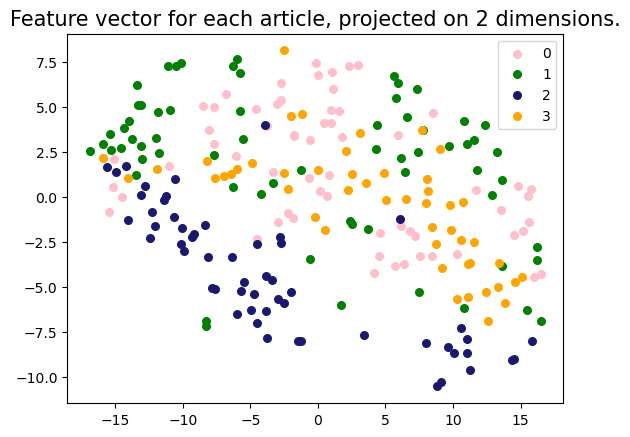

In [36]:
plotTSNE(pd.Series(categories), unweighted_preTW2v_dvs.to_numpy())

#### TF-IDF Weighted

In [38]:
weighted_preTW2v_dvs = gen_docVecs(preTW2v_wv, tk_descriptions, tfidf_weights)

In [39]:
weighted_preTW2v_dvs

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.127735,0.235061,-0.086524,0.003810,0.120681,0.217154,-0.104117,-0.508286,0.443325,0.306826,...,-0.636729,0.271189,-0.418535,0.010197,-0.141266,0.098013,-0.037712,-0.128682,-0.087839,-0.341490
1,0.072223,0.150872,0.217045,0.226054,0.107462,-0.065670,0.024513,-0.466990,0.751906,-0.156715,...,-0.380454,0.623265,-0.290799,0.262206,0.067257,-0.068819,0.117884,0.066299,-0.031979,0.006392
2,-0.322412,-0.033755,-0.006769,-0.058533,-0.280152,-0.129906,0.216074,-0.449664,0.314796,-0.083322,...,-0.452964,0.099408,-0.338833,0.042622,-0.048744,0.134967,-0.057996,-0.344080,0.021213,-0.178418
3,-0.113855,0.325437,-0.143501,0.205663,-0.289510,-0.264339,0.072500,-0.284336,0.315983,0.337004,...,-0.384992,0.371126,-0.330034,0.101861,-0.123601,0.073506,0.404387,0.064453,-0.073978,-0.013935
4,-0.236785,0.018763,-0.111336,0.324455,-0.393914,-0.289901,0.446163,-0.459797,0.472943,0.293615,...,-0.416899,0.203973,-0.539202,0.032364,-0.077112,0.421060,-0.106325,-0.055864,-0.002660,-0.323667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,-0.125609,-0.016792,-0.368704,0.205622,0.224300,-0.152075,-0.094676,-0.526553,0.437968,0.411523,...,-0.363835,0.231408,-0.872783,-0.060109,0.298475,-0.016588,0.531132,-0.134259,0.081906,-0.401122
772,-0.604732,0.578274,0.103259,0.188739,-0.533520,-0.160373,0.652303,-0.637050,0.814923,0.706039,...,-1.117223,0.643935,-0.958765,0.526360,-0.426958,0.371385,0.134486,-0.132689,0.004111,-0.504844
773,-0.411729,0.485789,-0.249535,0.172692,-0.528066,0.299471,0.164593,-1.012732,0.486946,-0.423266,...,-0.546662,0.447070,-1.007018,0.270806,0.040386,0.331095,0.545481,0.075594,0.452824,0.161510
774,-0.109460,0.124760,-0.301339,0.263627,-0.620124,0.543031,0.239732,-0.606416,0.352809,0.071686,...,-0.191264,0.408702,-0.596113,0.083482,0.042501,0.180732,-0.001663,0.136835,0.305062,-0.160340


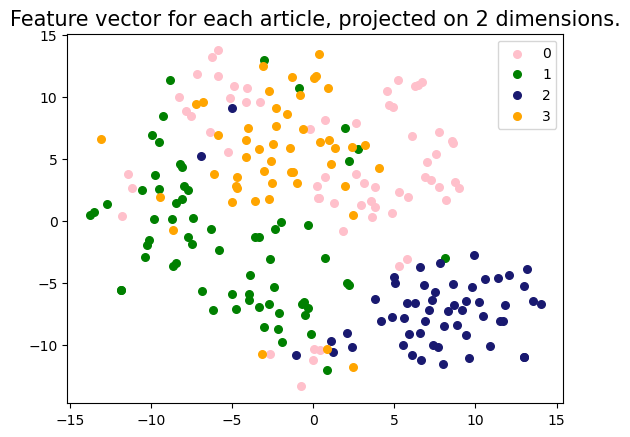

In [40]:
plotTSNE(pd.Series(categories), weighted_preTW2v_dvs.to_numpy())

## 3. Generating Feature Representations for Job Advertisement Titles

### 3.1. Count Features

In [43]:
title_cVectorizer = CountVectorizer(analyzer = "word",vocabulary = titles_vocab)

In [44]:
titles_count_features = title_cVectorizer.fit_transform([" ".join(title) for title in tk_titles]) # generate the count vector representation for all articles
print(titles_count_features.shape)

(776, 363)


### 3.2. TF-IDF Features

In [46]:
title_tVectorizer = TfidfVectorizer(analyzer = "word",vocabulary = titles_vocab) 

In [47]:
titles_tfidf_features = title_tVectorizer.fit_transform([" ".join(title) for title in tk_titles]) # generate the count vector representation for all articles
print(titles_count_features.shape)

(776, 363)


## 4. Job Advertisement Classification
Since the dataset is small, models were trained using `LogisticRegression` and additionally, `Support Vector Machine` due to its ability to handle large feature space.

Models performance were evaluated using **5 folds cross validation** with 4 different sets of features presentation: `count vectors`, `tfidf vectors`, and additional `unweighted-doc2vec` and `tfidf-weighted-doc2vec` retrieved from word embeddings using **word2vec-google-300**.

Experiments on using the **titles representation** instead of the descriptions and using **both** were also conducted to see whether the models performance vary regardings the amount of data provided for training.

#### Labels Examination

Text(0, 0.5, 'Count')

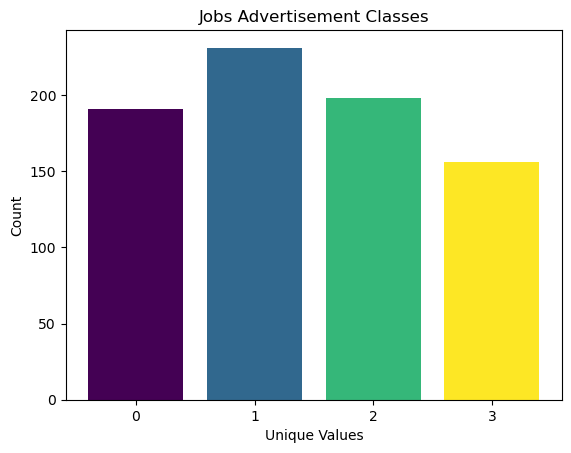

In [50]:
# Get unique values of labels and their counts
unique_categories_values, counts = np.unique(categories, return_counts=True)

# Display the results
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_categories_values)))

# Plot the results
plt.bar(unique_categories_values, counts, color=colors)

# Add titles and labels
plt.title('Jobs Advertisement Classes')
plt.xlabel('Unique Values')
plt.ylabel('Count')


The target variable is **not imbalanced**. It is adequate to use `accuracy score` as the primary metrics for models evaluation.

In [52]:
def evaluate(model, X_train,X_test,y_train, y_test,seed):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test) # accuracy

In [53]:
# define the 5 folds
seed = 15
num_folds = 5
kf = KFold(n_splits= num_folds, random_state=seed, shuffle = True)

In [54]:
# define the 5 folds validation function
def five_folds_validate_model(model, labels = categories, count_features = count_features, tfidf_features = tfidf_features, tfidf_weighted=pd.DataFrame(), unweighted = pd.DataFrame()):
    
    cv_df = pd.DataFrame(columns = ['count','tf-idf', 'unweighted','tfidf-weighted'],index=range(num_folds)) # creates a dataframe to store the accuracy scores in all the folds

    fold = 0
    for train_index, test_index in kf.split(list(range(0,len(labels)))):
    
        y_train = [str(categories[i]) for i in train_index]
        y_test = [str(categories[i]) for i in test_index]

       
        X_train_count, X_test_count = count_features[train_index], count_features[test_index]
        cv_df.loc[fold,'count'] = evaluate(model, count_features[train_index],count_features[test_index],y_train,y_test,seed)

        X_train_tfidf, X_test_tfidf = tfidf_features[train_index], tfidf_features[test_index]
        cv_df.loc[fold,'tf-idf'] = evaluate(model, tfidf_features[train_index],tfidf_features[test_index],y_train,y_test,seed)
        
        if not unweighted.empty:
            X_train_unweighted, X_test_count = unweighted.to_numpy()[train_index], unweighted.to_numpy()[test_index]
            cv_df.loc[fold,'unweighted'] = evaluate(model, unweighted.to_numpy()[train_index],unweighted.to_numpy()[test_index],y_train,y_test,seed)
        
        if not tfidf_weighted.empty:
            X_train_tfidf_weighted, X_test_tfidf = tfidf_weighted.to_numpy()[train_index], tfidf_weighted.to_numpy()[test_index]
            cv_df.loc[fold,'tfidf-weighted'] = evaluate(model, tfidf_weighted.to_numpy()[train_index],tfidf_weighted.to_numpy()[test_index],y_train,y_test,seed)
        
        fold +=1
    return cv_df.dropna(axis=1)

### 4.1. With Descriptions Only

#### Logistic Regression

In [57]:
lr = LogisticRegression(random_state=seed,max_iter = 1000)

lr_cv_df = five_folds_validate_model(lr, tfidf_weighted= weighted_preTW2v_dvs, unweighted = unweighted_preTW2v_dvs)

In [58]:
display(lr_cv_df)

print('Mean accuracy of Logistic Regression with Descriptions: ')
print(lr_cv_df.mean())

,count,tf-idf,unweighted,tfidf-weighted
0,0.878205,0.891026,0.807692,0.826923
1,0.864516,0.909677,0.83871,0.877419
2,0.870968,0.883871,0.819355,0.877419
3,0.883871,0.883871,0.806452,0.83871
4,0.858065,0.858065,0.825806,0.845161


Mean accuracy of Logistic Regression with Descriptions: 
count             0.871125
tf-idf            0.885302
unweighted        0.819603
tfidf-weighted    0.853127
dtype: object


The predictions made by logistic regression model that is trained with tf-idf features were more accurate.

#### Support Vector Machine

In [61]:
svm = SVC(kernel='linear')

svm_cv_df = five_folds_validate_model(svm, tfidf_weighted= weighted_preTW2v_dvs, unweighted = unweighted_preTW2v_dvs)

In [62]:
display(svm_cv_df)

print('Mean accuracy of Support Vector Machine with Descriptions: ')
print(svm_cv_df.mean())

,count,tf-idf,unweighted,tfidf-weighted
0,0.858974,0.884615,0.801282,0.794872
1,0.851613,0.903226,0.812903,0.858065
2,0.864516,0.903226,0.819355,0.851613
3,0.858065,0.896774,0.793548,0.8
4,0.83871,0.870968,0.806452,0.793548


Mean accuracy of Support Vector Machine with Descriptions: 
count             0.854376
tf-idf            0.891762
unweighted        0.806708
tfidf-weighted     0.81962
dtype: object


The predictions made by SVM model that is trained with tf-idf features were more accurate. Additionally, it was also better than the Logistic Regression score while the result on count features was lower.

In both models, the two word-embeddings features were not as effective as the other two.

### 4.2. With Titles Only
For the titles, only `count_features` and `tfidf_features` of them are used due to the belief that the word-embeddings approach were inadequate.

#### Logistic Regression

In [66]:
lr_titles_cv_df = five_folds_validate_model(lr,count_features=titles_count_features, tfidf_features=titles_tfidf_features)

In [67]:
display(lr_titles_cv_df)

print('Mean accuracy of Logistic Regression with Titles: ')
print(lr_titles_cv_df.mean())

,count,tf-idf
0,0.820513,0.839744
1,0.845161,0.858065
2,0.825806,0.870968
3,0.812903,0.787097
4,0.83871,0.845161


Mean accuracy of Logistic Regression with Titles: 
count     0.828619
tf-idf    0.840207
dtype: object


#### Support Vector Machine

In [69]:
svm_titles_cv_df = five_folds_validate_model(svm, count_features=titles_count_features, tfidf_features=titles_tfidf_features)

In [70]:
display(svm_titles_cv_df)

print('Mean accuracy of Support Vector Machine with Titles: ')
print(svm_titles_cv_df.mean())

,count,tf-idf
0,0.807692,0.852564
1,0.787097,0.858065
2,0.819355,0.858065
3,0.787097,0.819355
4,0.825806,0.819355


Mean accuracy of Support Vector Machine with Titles: 
count     0.805409
tf-idf    0.841481
dtype: object


### 4.3. With Both Titles and Descriptions

#### Logistic Regression

In [73]:
combined_count_features = hstack([count_features, titles_count_features])
combined_tfidf_features = hstack([tfidf_features, titles_tfidf_features])

In [74]:
lr_combined_cv_df = five_folds_validate_model(lr,count_features=combined_count_features, tfidf_features=combined_tfidf_features)

In [75]:
display(lr_combined_cv_df)

print('Mean accuracy of Logistic Regression with both Titles and Descriptions: ')
print(lr_combined_cv_df.mean())

,count,tf-idf
0,0.897436,0.916667
1,0.890323,0.909677
2,0.870968,0.896774
3,0.883871,0.883871
4,0.864516,0.858065


Mean accuracy of Logistic Regression with both Titles and Descriptions: 
count     0.881423
tf-idf    0.893011
dtype: object


#### Support Vector Machine

In [77]:
svm_combined_cv_df = five_folds_validate_model(svm,count_features=combined_count_features, tfidf_features=combined_tfidf_features)

In [78]:
display(svm_combined_cv_df)

print('Mean accuracy of Support Vector Machine with both Titles and Descriptions: ')
print(svm_combined_cv_df.mean())

,count,tf-idf
0,0.891026,0.891026
1,0.864516,0.909677
2,0.864516,0.883871
3,0.883871,0.870968
4,0.851613,0.858065


Mean accuracy of Support Vector Machine with both Titles and Descriptions: 
count     0.871108
tf-idf    0.882721
dtype: object


### 4.4. Final Evaluation
|Models                     |count    |tf-idf       |unweighted    |tfidf-weighted |
|---------------------------|---------|-------------|--------------|---------------|
|LR with descriptions       |0.871125 |0.885302     |0.818313      |0.853127       |
|SVM with descriptions      |0.854376 |**0.891762** |0.806708      |0.81962        |

Overall, `Logistic Regression` scores were better than `SVM` on most of the features representation except for the **tf-idf**, which was at 0.891 and also the highest average accuracy an approach could score on descriptions features. Both word-embedding features got lower scores than the other two, but as within those two only, the **tfidf weighted** set delivered better results for both models (0.853 for Logistic Regression and 0.819 for SVM). 


|Models                               |count                                    |tf-idf                                      |
|-------------------------------------|-----------------------------------------|--------------------------------------------|
|LR with descriptions                 |0.871125                                 |0.885302                                    |
|LR with titles                       |<span style="color:red">0.828619</span>  |<span style="color:red">0.840207</span>     |
|LR with both titles and descriptions |<span style="color:blue">0.881423</span> |<span style="color:blue">**0.893011**</span>|
|SVM with descriptions                |0.854376                                 |0.891762                                    |
|SVM with titles                      |<span style="color:red">0.805409</span>  |<span style="color:red">0.841481</span>     |
|SVM with both titles and descriptions|<span style="color:blue"> 0.871108</span>|<span style="color:red">0.882721</span>     |

By conducting the training process on the ***Titles***, the overall accuracy decreased significantly. Meanwhile, with the addition of ***Titles*** features, the results were slightly better. For `Logistic Regression` models the accuracy increased from 0.871 to 0.881 regarding count_features and from 0.885 to 0.893 regarding tfidf_features. Same with `SVM`, the score on count_features went up to 0.871 (by 0.02) but slightly decrease on tfidf_features. It can be concluded that with more data and information, we can considerably train more accurate models.

The best models is **Logistic Regression with tf-idf of Titles and Descriptions**


